<a href="https://colab.research.google.com/github/jimtoberfest/MotoGP_PowerRankings/blob/main/MotoGP_MultiELO_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+git://github.com/djcunningham0/multielo.git

  Cloning git://github.com/djcunningham0/multielo.git to /tmp/pip-req-build-pf4jmyrn
  Running command git clone -q git://github.com/djcunningham0/multielo.git /tmp/pip-req-build-pf4jmyrn
  Created wheel for multielo: filename=multielo-0.3.0-py3-none-any.whl size=14871 sha256=fce259cb5cd7921689ba18320a27b911cbcb6e09b5eb342b3098980d93c4f21d
  Stored in directory: /tmp/pip-ephem-wheel-cache-itpvdbuk/wheels/99/eb/93/fce8c6b56a05c14c6619d733aa351d99bca529f013489c24d3
Successfully built multielo


In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import itertools
from itertools import permutations

from multielo import MultiElo, Player, Tracker

import math


# %matplotlib notebook


# RESETS ANY POTENTIAL RUNTIME ISSUES WITH MATPLOTLIB
%matplotlib inline
plt.close('all')

In [89]:
path = '/content/drive/MyDrive/'
file = 'MotoGP_raw_data_1.xlsx'

data = pd.read_excel(path + file)

#Functions

In [90]:
def seed_it(df_column):
  primary_list = list(df_column.unique())

  start_values = []
  for i in range(len(primary_list)):
    s_seed = 1000 + (1 if np.random.random() < 0.5 else -1)
    start_values.append(s_seed)

  return dict(zip(primary_list, start_values))

# Cleaning

In [91]:
df = data.copy()

In [92]:
df.columns= df.columns.str.strip().str.lower()
df.columns = [c.replace(".", "") for c in df.columns]
df.drop([2340], inplace=True)  #remove cancelled Silverstone race
df = df.fillna(0)
df = df.replace(['nan', 'None'], 0)
df.reset_index(drop=True,inplace=True)

In [93]:
df.tail(27)

,race_num,track,season,pos,points,num,rider,nation,team,bike,kph,time_gap,laps_before_out
3565,17,portimao,2021,16,0,12.0,Maverick VIÑALES,SPA,Aprilia Racing Team Gresini,Aprilia,163.5,26.828,0
3566,17,portimao,2021,17,0,21.0,Franco MORBIDELLI,ITA,Monster Energy Yamaha MotoGP,Yamaha,163.4,27.863,0
3567,17,portimao,2021,0,0,88.0,Miguel OLIVEIRA,POR,Red Bull KTM Factory Racing,KTM,164.4,1 Lap,1
3568,17,portimao,2021,0,0,27.0,Iker LECUONA,SPA,Tech 3 KTM Factory Racing,KTM,164.3,1 Lap,1
3569,17,portimao,2021,0,0,20.0,Fabio QUARTARARO,FRA,Monster Energy Yamaha MotoGP,Yamaha,164.8,3 Laps,3
3570,17,portimao,2021,0,0,41.0,Aleix ESPARGARO,SPA,Aprilia Racing Team Gresini,Aprilia,162.9,16 Laps,16
3571,17,portimao,2021,0,0,9.0,Danilo PETRUCCI,ITA,Tech 3 KTM Factory Racing,KTM,0.0,0 La,0
3572,18,valencia,2021,1,25,63.0,Francesco BAGNAIA,ITA,Ducati Lenovo Team,Ducati,157.2,41'15.481,0
3573,18,valencia,2021,2,20,89.0,Jorge MARTIN,SPA,Pramac Racing,Ducati,157.2,0.489,0
3574,18,valencia,2021,3,16,43.0,Jack MILLER,AUS,Ducati Lenovo Team,Ducati,157.2,0.823,0


#Feature Engineering

In [94]:
df['pos_calcd'] =  df.groupby(['race_num', 'track','season'])['pos'].transform(lambda x: pd.Series(range(1, len(x)+1), index=x.index))
df['pos_c_minus_1'] = df['pos_calcd'].shift(-1)

In [95]:
factory_list = ['Yamaha Factory Racing', 'Repsol Honda Team','Movistar Yamaha MotoGP','Team Suzuki MotoGP','Team SUZUKI ECSTAR','Aprilia Racing Team Gresini','Yamaha Factory Racing Team','Yamalube Yamaha Factory Racing',
                'Red Bull KTM Factory Racing','Red Bull KTM Factory Racing','Mission Winnow Ducati', 'Monster Energy Yamaha MotoGP','Aprilia Factory Racing', 'Team HRC', 'Aprilia Racing Team', 'Ducati Team',
                'Ducati Lenovo Team']

In [96]:
df['bike_calcd'] = df.apply(lambda x:  str(x['bike']) + '_sat' if x['team'] not in factory_list else x['bike'], axis = 1)
df['rider_bike'] = df['rider'] + '_' + df['bike_calcd']
df['track_bike'] = df['track'] + '_' + df['bike_calcd']
df['track_bike_rider'] = df['track_bike'] + '_' + df['rider']

In [97]:
df.head(2)

,race_num,track,season,pos,points,num,rider,nation,team,bike,kph,time_gap,laps_before_out,pos_calcd,pos_c_minus_1,bike_calcd,rider_bike,track_bike,track_bike_rider
0,1,losail,2013,1,25,99.0,Jorge LORENZO,SPA,Yamaha Factory Racing,Yamaha,166.4,42'39.802,0,1,2.0,Yamaha,Jorge LORENZO_Yamaha,losail_Yamaha,losail_Yamaha_Jorge LORENZO
1,1,losail,2013,2,20,46.0,Valentino ROSSI,ITA,Yamaha Factory Racing,Yamaha,166.0,5.99,0,2,3.0,Yamaha,Valentino ROSSI_Yamaha,losail_Yamaha,losail_Yamaha_Valentino ROSSI


In [98]:
year_list = list(df['season'].unique())
# year_list.pop(-1)
year_list

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Initial Seeding

In [99]:
rider_bikes = seed_it(df['rider_bike'])
# rider_bikes

# ELO Runs

### Set initial parameters for ELO runs

In [100]:
elo_custom = MultiElo(k_value=24, d_value=400, score_function_base=1.2)

### Create empty DF to hold results

In [101]:

df_bulk_columns = ['track', 'season', 'pos_calcd', 'rider_bike', 'curr_elo',
       'pre_race_pred', 'new_elo']

df_bulk = pd.DataFrame(columns = df_bulk_columns)

In [102]:
df_bulk

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo


### THE LOOP

In [103]:
# Loop Should be HERE for Production

'''
Approx Loop Time for Entire Dataset (2013 - 2021) is:  305 seconds

'''
for year in range(len(year_list)):


  # year = 2013

  df_race_count = df[df['season'] == year_list[year]]

  for j in range(df_race_count['race_num'].max()):
    # print(j)
    dfr = df[(df['race_num'] == j+1) & (df['season'] == year_list[year])]  #j then i for the looping
    dfr = dfr[['track', 'season', 'pos_calcd','rider_bike']]
    dfr['curr_elo'] = df['rider_bike'] .apply(lambda x: rider_bikes[x])
    # dfr.head(5)
    
    elo_0 = list(dfr['curr_elo'])
    win_probability = elo_custom.simulate_win_probabilities(elo_0)
    predicted_place_pre_race = []
    for k in range(len(win_probability)):
      max_index_col = np.argmax(win_probability[k], axis=0)
      predicted_place_pre_race.append(max_index_col)

    dfr['pre_race_pred'] = predicted_place_pre_race
    
    #Get new ratings and add to df
    elo_new = elo_custom.get_new_ratings(elo_0)
    dfr['new_elo'] = elo_new.tolist()

    # push elo_new to rider_bikes dict

    for u in range(len(dfr['new_elo'])):
      name = dfr.iloc[u]['rider_bike']
      score = dfr.iloc[u]['new_elo']
      rider_bikes[name] = score

    frames =[df_bulk, dfr]
    df_bulk = pd.concat(frames, ignore_index=True)
    # End Inner Loop


  # Partial PowerRank Reset Post-Season
  for k, v in rider_bikes.items():
      rider_bikes[k] = v + (((v - 1000) / 2)*-1)
  #End Outer Loop


In [104]:
df_bulk

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
0,losail,2013,1,Jorge LORENZO_Yamaha,999,3,1073.805764
1,losail,2013,2,Valentino ROSSI_Yamaha,999,22,1057.265685
2,losail,2013,3,Marc MARQUEZ_Honda,1001,19,1045.344133
3,losail,2013,4,Dani PEDROSA_Honda,1001,0,1033.857967
4,losail,2013,5,Cal CRUTCHLOW_Yamaha_sat,1001,5,1024.286162
...,...,...,...,...,...,...,...
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.508,14,941.859362
7180,valencia,2021,17,Luca MARINI_Ducati_sat,863.568,19,851.378734
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,837.514,19,825.911885
7182,valencia,2021,19,Alex RINS_Suzuki,1058.35,8,1033.427527


In [105]:
df_bulk.tail(27)

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
7157,portimao,2021,16,Maverick VIÑALES_Aprilia,975.39,15,958.508045
7158,portimao,2021,17,Franco MORBIDELLI_Yamaha,950.434,18,934.058008
7159,portimao,2021,18,Miguel OLIVEIRA_KTM,980.032,16,961.020443
7160,portimao,2021,19,Iker LECUONA_KTM_sat,845.328,21,833.447114
7161,portimao,2021,20,Fabio QUARTARARO_Yamaha,1439.11,0,1398.114469
7162,portimao,2021,21,Aleix ESPARGARO_Aprilia,1003.85,13,981.621944
7163,portimao,2021,22,Danilo PETRUCCI_KTM_sat,851.182,21,837.513661
7164,valencia,2021,1,Francesco BAGNAIA_Ducati,1323.37,0,1369.970323
7165,valencia,2021,2,Jorge MARTIN_Ducati_sat,1029.43,11,1075.746354
7166,valencia,2021,3,Jack MILLER_Ducati,1142.93,5,1170.740508


In [106]:
df_final_riderb_ranks = df_bulk.groupby(['season', 'rider_bike'])['new_elo'].max().reset_index().sort_values('new_elo', ascending=False)
print(len(df_final_riderb_ranks))
df_final_riderb_ranks.head(50)

291


,season,rider_bike,new_elo
219,2019,Marc MARQUEZ_Honda,2126.146908
83,2015,Jorge LORENZO_Yamaha,1952.448122
102,2015,Valentino ROSSI_Yamaha,1938.483563
53,2014,Marc MARQUEZ_Honda,1928.558719
187,2018,Marc MARQUEZ_Honda,1865.147320
156,2017,Marc MARQUEZ_Honda,1760.553272
122,2016,Marc MARQUEZ_Honda,1721.968260
88,2015,Marc MARQUEZ_Honda,1720.000696
49,2014,Jorge LORENZO_Yamaha,1712.348257
19,2013,Jorge LORENZO_Yamaha,1691.967728


# Explore some results, rank riders

In [107]:
dfrb = pd.DataFrame(rider_bikes.items(), columns=['rider_bike', 'PowerRank']).sort_values('PowerRank', ascending=False)
dfrbA = dfrb[(dfrb['PowerRank'] != 1001.0) & (dfrb['PowerRank'] != 999.0) ]
print('MAX: ', dfrbA['PowerRank'].max())
print('MIN: ', dfrbA['PowerRank'].min())
dfrbA.reset_index(drop=True, inplace=True)
dfrbA.head(25)

MAX:  1198.567130228511
MIN:  912.4610733794149


,rider_bike,PowerRank
0,Fabio QUARTARARO_Yamaha,1198.567130
1,Francesco BAGNAIA_Ducati,1184.985162
2,Marc MARQUEZ_Honda,1157.539714
3,Joan MIR_Suzuki,1141.569688
4,Jack MILLER_Ducati,1085.370254
5,Maverick VIÑALES_Yamaha,1057.602792
6,Johann ZARCO_Ducati_sat,1055.420135
7,Andrea DOVIZIOSO_Ducati,1053.080974
8,Jack MILLER_Ducati_sat,1041.231138
9,Jorge MARTIN_Ducati_sat,1037.873177


In [108]:
  # rider_bikes

In [109]:
odds = 1 / (1 + (10**((dfrbA['PowerRank'][3]-dfrbA['PowerRank'][2])/400)))
odds

0.5229665425404566

# Correcting Function for each season

In [110]:
chk_stp = []
contracted = []
unknowny = []

for i in range(100, 2500, 50):
  chk_stp.append(i)
  m = i + (((i - 1000) / 2)*-1)
  q = (i + ((((i - 1000)*float(.10))**float(1.39))*-1))
  q = q.real + q.imag
  unknowny.append(q)
  contracted.append(m)

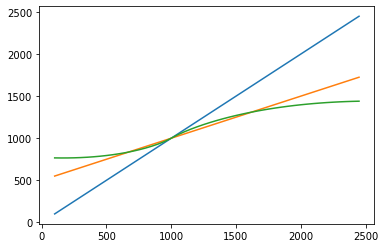

In [111]:
plt.plot(chk_stp, chk_stp)
plt.plot(chk_stp, contracted)
plt.plot(chk_stp, unknowny)

In [112]:
arr1 = np.array(chk_stp)
arr2 = np.array(contracted)
arr3 = np.array(unknowny)

In [113]:
print(arr3.mean())
print(arr3.std())

1120.6136680690609
255.24577372769167


In [114]:
print(arr2.mean())
print(arr2.std())

1137.5
346.3349775386059


In [115]:
(500 * .10)**1.5

353.5533905932738

In [116]:
(((1500)*.10)**1.5)


1837.1173070873836

In [117]:
# Partial PowerRank Reset Post-Season

for k, v in rider_bikes.items():
    rider_bikes[k] = v + (((v - 1000) / 2)*-1)

In [118]:
rider_bikes

{'Aleix ESPARGARO_ART_sat': 999.9071809143383,
 'Aleix ESPARGARO_Aprilia': 994.5646972627483,
 'Aleix ESPARGARO_Suzuki': 999.6916503298656,
 'Aleix ESPARGARO_Yamaha Forward_sat': 1000.069953697079,
 'Alex DE ANGELIS_ART_sat': 999.2476601902015,
 'Alex DE ANGELIS_Ducati_sat': 999.9901401604989,
 'Alex DE ANGELIS_Yamaha Forward_sat': 999.8177609715982,
 'Alex LOWES_Yamaha_sat': 999.7550947206472,
 'Alex MARQUEZ_Honda': 997.874721533524,
 'Alex MARQUEZ_Honda_sat': 976.5052024527215,
 'Alex RINS_Suzuki': 1008.3568818060969,
 'Alvaro BAUTISTA_Aprilia': 999.2206984958052,
 'Alvaro BAUTISTA_Ducati': 1000.9677961529997,
 'Alvaro BAUTISTA_Ducati_sat': 999.6211813432147,
 'Alvaro BAUTISTA_Honda_sat': 999.9687592311816,
 'Andrea DOVIZIOSO_Ducati': 1026.5404869812228,
 'Andrea DOVIZIOSO_Yamaha_sat': 983.5248440486869,
 'Andrea IANNONE_Aprilia': 991.0168924646918,
 'Andrea IANNONE_Ducati': 1001.2770540830643,
 'Andrea IANNONE_Ducati_sat': 999.9540625383502,
 'Andrea IANNONE_Suzuki': 1000.6004195602

# Further Exploration

In [119]:
df_bulk.tail()

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.508,14,941.859362
7180,valencia,2021,17,Luca MARINI_Ducati_sat,863.568,19,851.378734
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,837.514,19,825.911885
7182,valencia,2021,19,Alex RINS_Suzuki,1058.35,8,1033.427527
7183,valencia,2021,20,Takaaki NAKAGAMI_Honda_sat,928.503,17,910.674204


## Tentative Calcs

In [120]:

# df_bulk.fillna(0, inplace=True)

# Create copy
df_detail = df_bulk.copy()

# Selection params

# df_detail = df_bulk[df_bulk['rider_bike'] == 'Valentino ROSSI_Yamaha' ].reset_index()

# dfd = df_detail[df_detail['season'] == 2015]

# dfd = df_detail[df_detail['pos_calcd'] == 1]
# dfd = df_detail[ (df_detail['pos_calcd'] == 1) & (df_detail['rider_bike'] != 'Marc MARQUEZ_Honda') & (df_detail['season'] != 2013)]
dfd = df_detail[(df_detail['season'] != 2013)]


# dfd = df_detail.copy()


# Features
dfd['pre_race_pred'] = dfd['pre_race_pred'] + 1
dfd['place_diff'] = (dfd['pre_race_pred'] + 0) - dfd['pos_calcd']
dfd['bool_winner_pred'] = dfd['place_diff'].apply(lambda x:  1 if x == 0 else 0)
dfd['abs_error'] = abs(dfd['place_diff'])


print( 'MEAN:', dfd['place_diff'].mean())
print( 'std:', dfd['place_diff'].std())
print('dfd len:', len(dfd))
print( 'count:', dfd['bool_winner_pred'].sum())
print( 'accuracy:', (dfd['bool_winner_pred'].sum() / len(dfd)))
print( 'acc - Marquez naive guess:', (dfd['bool_winner_pred'].sum() / len(dfd) - .44))
print(dfd['place_diff'].max())
dfd

MEAN: 2.6143398610233732
std: 7.243935393873908
dfd len: 6758
count: 238
accuracy: 0.03521751997632436
acc - Marquez naive guess: -0.4047824800236757
21


,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo,place_diff,bool_winner_pred,abs_error
426,losail,2014,1,Marc MARQUEZ_Honda,1329.33,1,1385.790551,0,1,0
427,losail,2014,2,Valentino ROSSI_Yamaha,1194.58,5,1241.170381,3,0,3
428,losail,2014,3,Dani PEDROSA_Honda,1295.04,1,1323.500073,-2,0,2
429,losail,2014,4,Aleix ESPARGARO_Yamaha Forward_sat,1000.5,19,1034.256204,15,0,15
430,losail,2014,5,Andrea DOVIZIOSO_Ducati,1010.29,17,1034.158986,12,0,12
...,...,...,...,...,...,...,...,...,...,...
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.508,15,941.859362,-1,0,1
7180,valencia,2021,17,Luca MARINI_Ducati_sat,863.568,20,851.378734,3,0,3
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,837.514,20,825.911885,2,0,2
7182,valencia,2021,19,Alex RINS_Suzuki,1058.35,9,1033.427527,-10,0,10


In [121]:
dfd[dfd['place_diff'] > 30]

dfd.fillna(0, inplace=True)

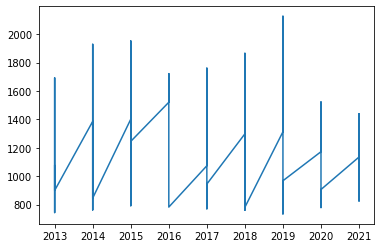

In [122]:
  plt.plot(df_detail['season'], df_detail['new_elo'])

(array([  43.,   91.,  188.,  378., 4734.,  817.,  439.,   68.]),
 array([-23. , -17.5, -12. ,  -6.5,  -1. ,   4.5,  10. ,  15.5,  21. ]),
 <a list of 8 Patch objects>)

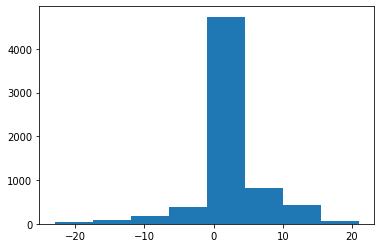

In [123]:
plt.hist(dfd['place_diff'], bins=8)

In [124]:
from sklearn import linear_model

# Initialize model
regression_model = linear_model.LinearRegression()

# Train the model using the mtcars data
regression_model.fit(X = pd.DataFrame(dfd['pre_race_pred']), 
                     y = dfd['pos_calcd'])

# Check trained model y-intercept
print(regression_model.intercept_)

# Check trained model coefficients
print(regression_model.coef_)

9.746658987768438
[-0.00358002]


In [125]:
regression_model.score(X = pd.DataFrame(dfd['pre_race_pred']), 
                     y = dfd['pos_calcd'])

0.4134441046432993

In [126]:
train_prediction = regression_model.predict(X = pd.DataFrame(dfd["pre_race_pred"]))

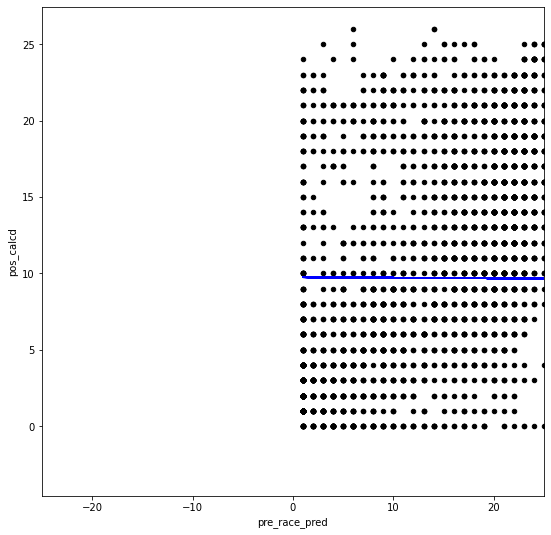

In [127]:

dfd.plot(kind="scatter",
           x="pre_race_pred",
           y="pos_calcd",
           figsize=(9,9),
           color="black",
           xlim = (-25,25))

# Plot regression line
plt.plot(dfd["pre_race_pred"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue");

In [128]:
dfd.head(10)

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo,place_diff,bool_winner_pred,abs_error
426,losail,2014,1,Marc MARQUEZ_Honda,1329.325678,1,1385.790551,0,1,0
427,losail,2014,2,Valentino ROSSI_Yamaha,1194.584354,5,1241.170381,3,0,3
428,losail,2014,3,Dani PEDROSA_Honda,1295.042837,1,1323.500073,-2,0,2
429,losail,2014,4,Aleix ESPARGARO_Yamaha Forward_sat,1000.500000,19,1034.256204,15,0,15
430,losail,2014,5,Andrea DOVIZIOSO_Ducati,1010.288848,17,1034.158986,12,0,12
431,losail,2014,6,Cal CRUTCHLOW_Ducati,999.500000,20,1016.321353,14,0,14
432,losail,2014,7,Scott REDDING_Honda_sat,999.500000,19,1009.882895,12,0,12
433,losail,2014,8,Nicky HAYDEN_Honda_sat,999.500000,20,1004.517514,12,0,12
434,losail,2014,9,Colin EDWARDS_Yamaha Forward_sat,999.500000,21,1000.046363,12,0,12
435,losail,2014,10,Andrea IANNONE_Ducati_sat,933.294137,23,934.168013,13,0,13


In [129]:
dfd['pos_calcd'] = pd.to_numeric(dfd['pos_calcd'], errors = 'coerce')
dfd['abs_error'] = pd.to_numeric(dfd['abs_error'], errors = 'coerce')

dfd_mae = dfd.groupby(['pos_calcd'])['abs_error'].mean().reset_index()
dfd_mae_B = dfd.groupby(['pos_calcd'])['abs_error'].std().reset_index()
# dfd_mae = dfd_mae.merge(dfd_mae_B,suffixes='_x')
# dfd_mae

In [130]:
dfd_m = dfd_mae.merge(dfd_mae_B, left_on='pos_calcd', right_on='pos_calcd',
          suffixes=('_left', '_right'))
dfd_m.rename(columns={'abs_error_left': 'MAE', 'abs_error_right': 'std'}, inplace=True)

In [131]:
dfd_m

,pos_calcd,MAE,std
0,0,0.000000,0.000000
1,1,3.200000,5.015372
2,2,4.421429,4.888789
3,3,4.978571,5.406455
4,4,5.335714,4.964059
5,5,6.085714,4.889404
6,6,6.757143,4.827784
7,7,7.092857,4.812897
8,8,6.764286,4.527471
9,9,7.235714,4.554404


In [132]:
df_final_riderb_ranks.head(25)

,season,rider_bike,new_elo
219,2019,Marc MARQUEZ_Honda,2126.146908
83,2015,Jorge LORENZO_Yamaha,1952.448122
102,2015,Valentino ROSSI_Yamaha,1938.483563
53,2014,Marc MARQUEZ_Honda,1928.558719
187,2018,Marc MARQUEZ_Honda,1865.147320
156,2017,Marc MARQUEZ_Honda,1760.553272
122,2016,Marc MARQUEZ_Honda,1721.968260
88,2015,Marc MARQUEZ_Honda,1720.000696
49,2014,Jorge LORENZO_Yamaha,1712.348257
19,2013,Jorge LORENZO_Yamaha,1691.967728


In [162]:
arc = df_final_riderb_ranks[(df_final_riderb_ranks['rider_bike'] == 'Alex RINS_Suzuki')]
arc.sort_values('season', inplace=True)

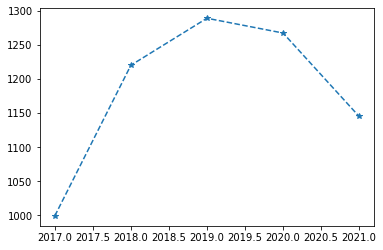

In [163]:
plt.plot(arc['season'], arc['new_elo'], linestyle='--', marker ='*')

In [166]:
s2021 = df_final_riderb_ranks[df_final_riderb_ranks['season'] == 2020].sort_values('new_elo', ascending=False, inplace=True)
s2021

<BarContainer object of 35 artists>

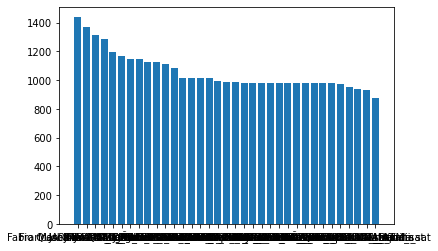

In [136]:
plt.bar(s2021['rider_bike'], s2021['new_elo'])

In [164]:
import plotly.express as px

In [168]:
df_final_riderb_ranks.sort_values('season', inplace=True)
fig = px.line(df_final_riderb_ranks, x="season", y="new_elo", color='rider_bike',
              markers=True)
fig.show()